# SADB19 vs. CVS-N2c comparisons

Jupyter notebook containing analyses for looking inflammatory and electrophysiological signatures of cells infected with SADB19 vs. CVS-N2c rabies from Shin & Urbanek.

This notebook contains analyses to look at cell type distributions, gene enrichment signatures, and differenecs in electrophysiological traits between rabies-infected cells coming from two different strains.

Input for this notebook requires:
1) Filtered metadata object derived from 10_transcriptome_visualization.ipynb
2) Electrophysiology recordings

Output for this notebook includes:
1) Plots showing the proportions of cells firing action potentials and distributions of electrophysiology properties 
2) Plots showing the proportions of each cell type between strains and pooled uninfected populations

Module and their versions used when generating figures for the paper can be found in 'requirements.txt', which is stored in our GitHub repository: https://github.com/MEUrbanek/rabies_barcode_tech

This code was last amended by Maddie Urbanek on 12/12/2025

## Notebook set-up

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats
import os
import math
from scipy.stats import binomtest
from scipy.stats import entropy
from scipy.stats import binom

pd.options.mode.chained_assignment = None
import scanpy as sc
import anndata as ad

In [2]:
import os
os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/ephys/')

In [3]:
#Set up plotting parameters
plt.rcParams['figure.figsize'] = [4,4]
plt.rc('font', family='Arial')
sc.set_figure_params(dpi=500, dpi_save=1000)

## Import data

In [4]:
metadata=pd.read_table('../transcriptome/filtered_metadata.csv',delimiter=',')
metadata

,Unnamed: 0,high_score,dataset_id,type_updated,umap_1,umap_2,broad_class,subclass,subclass_for_plotting,rabies_infected,helper_infected,viral_strain,dissociation_modality,age,infection_status
0,u1_AAAAAAACCCGAATAA,0.370670,u1,EN-Non-IT-Immature,-6.663230,-5.493468,EN,EN-Immature,EN-Immature,n,n,uninfected,cell,gw15-gw21,Uninfected
1,u2_ATACAGGCCAACCCTT,0.361953,u2,EN-L4-IT,-4.572668,-0.801976,EN,EN-L4-IT,EN-L4-IT,n,n,uninfected,nuc,gw15-gw21,Uninfected
2,u2_ATACATACATTTATAG,0.336753,u2,EN-L4-IT,-3.894848,-1.872069,EN,EN-L4-IT,EN-L4-IT,n,n,uninfected,nuc,gw15-gw21,Uninfected
3,u2_ATACATAAAGGCAGGG,0.383811,u2,EN-Newborn,0.265282,-1.520546,EN,EN-Immature,EN-Immature,n,n,uninfected,nuc,gw15-gw21,Uninfected
4,u2_ATACATAAAATCACTG,0.682225,u2,EN-L6-IT,-9.084895,-1.780544,EN,EN-Deep Layer,EN-Deep Layer,n,n,uninfected,nuc,gw15-gw21,Uninfected
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44882,s3_ATTCACAAATCCATGG,0.545707,s3,Astrocyte-Fibrous,10.312526,2.653120,Glia,Astrocyte,Astrocyte,y,y,SADB19,cell,gw22,Helper-infected
44883,s3_ATTCAGAAAAGTAACC,0.518470,s3,EN-L2_3-IT,-5.402542,-1.074406,EN,EN-L2_3-IT,EN-L2_3-IT,y,y,SADB19,cell,gw22,Helper-infected
44884,s3_ATTCAGTGATTGCCGA,0.587072,s3,EN-Newborn,-4.576743,-1.180227,EN,EN-Immature,EN-Immature,y,y,SADB19,cell,gw22,Helper-infected
44885,s3_ATTCCCGCACGGACTA,0.634164,s3,EN-L2_3-IT,-4.273514,-1.428039,EN,EN-L2_3-IT,EN-L2_3-IT,y,y,SADB19,cell,gw22,Helper-infected


In [5]:
recordings=pd.read_table('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/ephys/ephys_recordings.csv',delimiter=',')
recordings

,cell,date,gw,rmp_mv,cc_pf,ir_mohm,action_potential,strain
0,cvs_1,2024.07.19,18,-39.264659,34.208427,1029.043757,Y,cvs
1,cvs_2,2024.07.19,18,-30.471764,39.959304,1040.356655,Y,cvs
2,cvs_3,2024.07.19,18,-42.054620,32.878002,1393.681213,Y,cvs
3,cvs_4,2024.07.19,18,-33.548711,30.417823,1124.436570,N,cvs
4,cvs_5,2024.07.19,18,-36.846094,31.871962,1543.057735,Y,cvs
...,...,...,...,...,...,...,...,...
65,sadb19_30,2024.08.19,21,-10.449277,15.401710,2134.109803,N,sadb19
66,sadb19_31,2024.08.19,21,-16.123697,16.376124,3512.669911,N,sadb19
67,sadb19_32,2024.08.19,21,-41.964995,31.071158,1993.669162,Y,sadb19
68,sadb19_33,2024.08.19,21,-18.919621,19.579546,1125.174018,N,sadb19


### Action potential firing

In [18]:
#Format data
firing=pd.DataFrame(recordings.groupby('strain')['action_potential'].value_counts())
firing = firing.reset_index()
cvs_total=21+15
sad_total=30+4
firing['proportion']=firing['count']/[cvs_total,cvs_total,sad_total,sad_total]
firing

,strain,action_potential,count,proportion
0,cvs,Y,21,0.583333
1,cvs,N,15,0.416667
2,sadb19,N,30,0.882353
3,sadb19,Y,4,0.117647


In [25]:
#Clopper pearson error bars
print('Success 95% CI')
print('SADB19')
from scipy.stats import binomtest
result = binomtest(k=4, n=34, p=0.05)
print(result.proportion_ci())
print('CVS')
result = binomtest(k=21, n=36, p=0.05)
print(result.proportion_ci())

print('Failure 95% CI')
print('SADB19')
from scipy.stats import binomtest
result = binomtest(k=30, n=34, p=0.05)
print(result.proportion_ci())
print('CVS')
result = binomtest(k=15, n=36, p=0.05)
print(result.proportion_ci())

Success 95% CI
SADB19
ConfidenceInterval(low=0.03300168033630262, high=0.2745034871423557)
CVS
ConfidenceInterval(low=0.4075652408917766, high=0.7448589516737166)
Failure 95% CI
SADB19
ConfidenceInterval(low=0.7254965128576444, high=0.9669983196636973)
CVS
ConfidenceInterval(low=0.2551410483262834, high=0.5924347591082234)


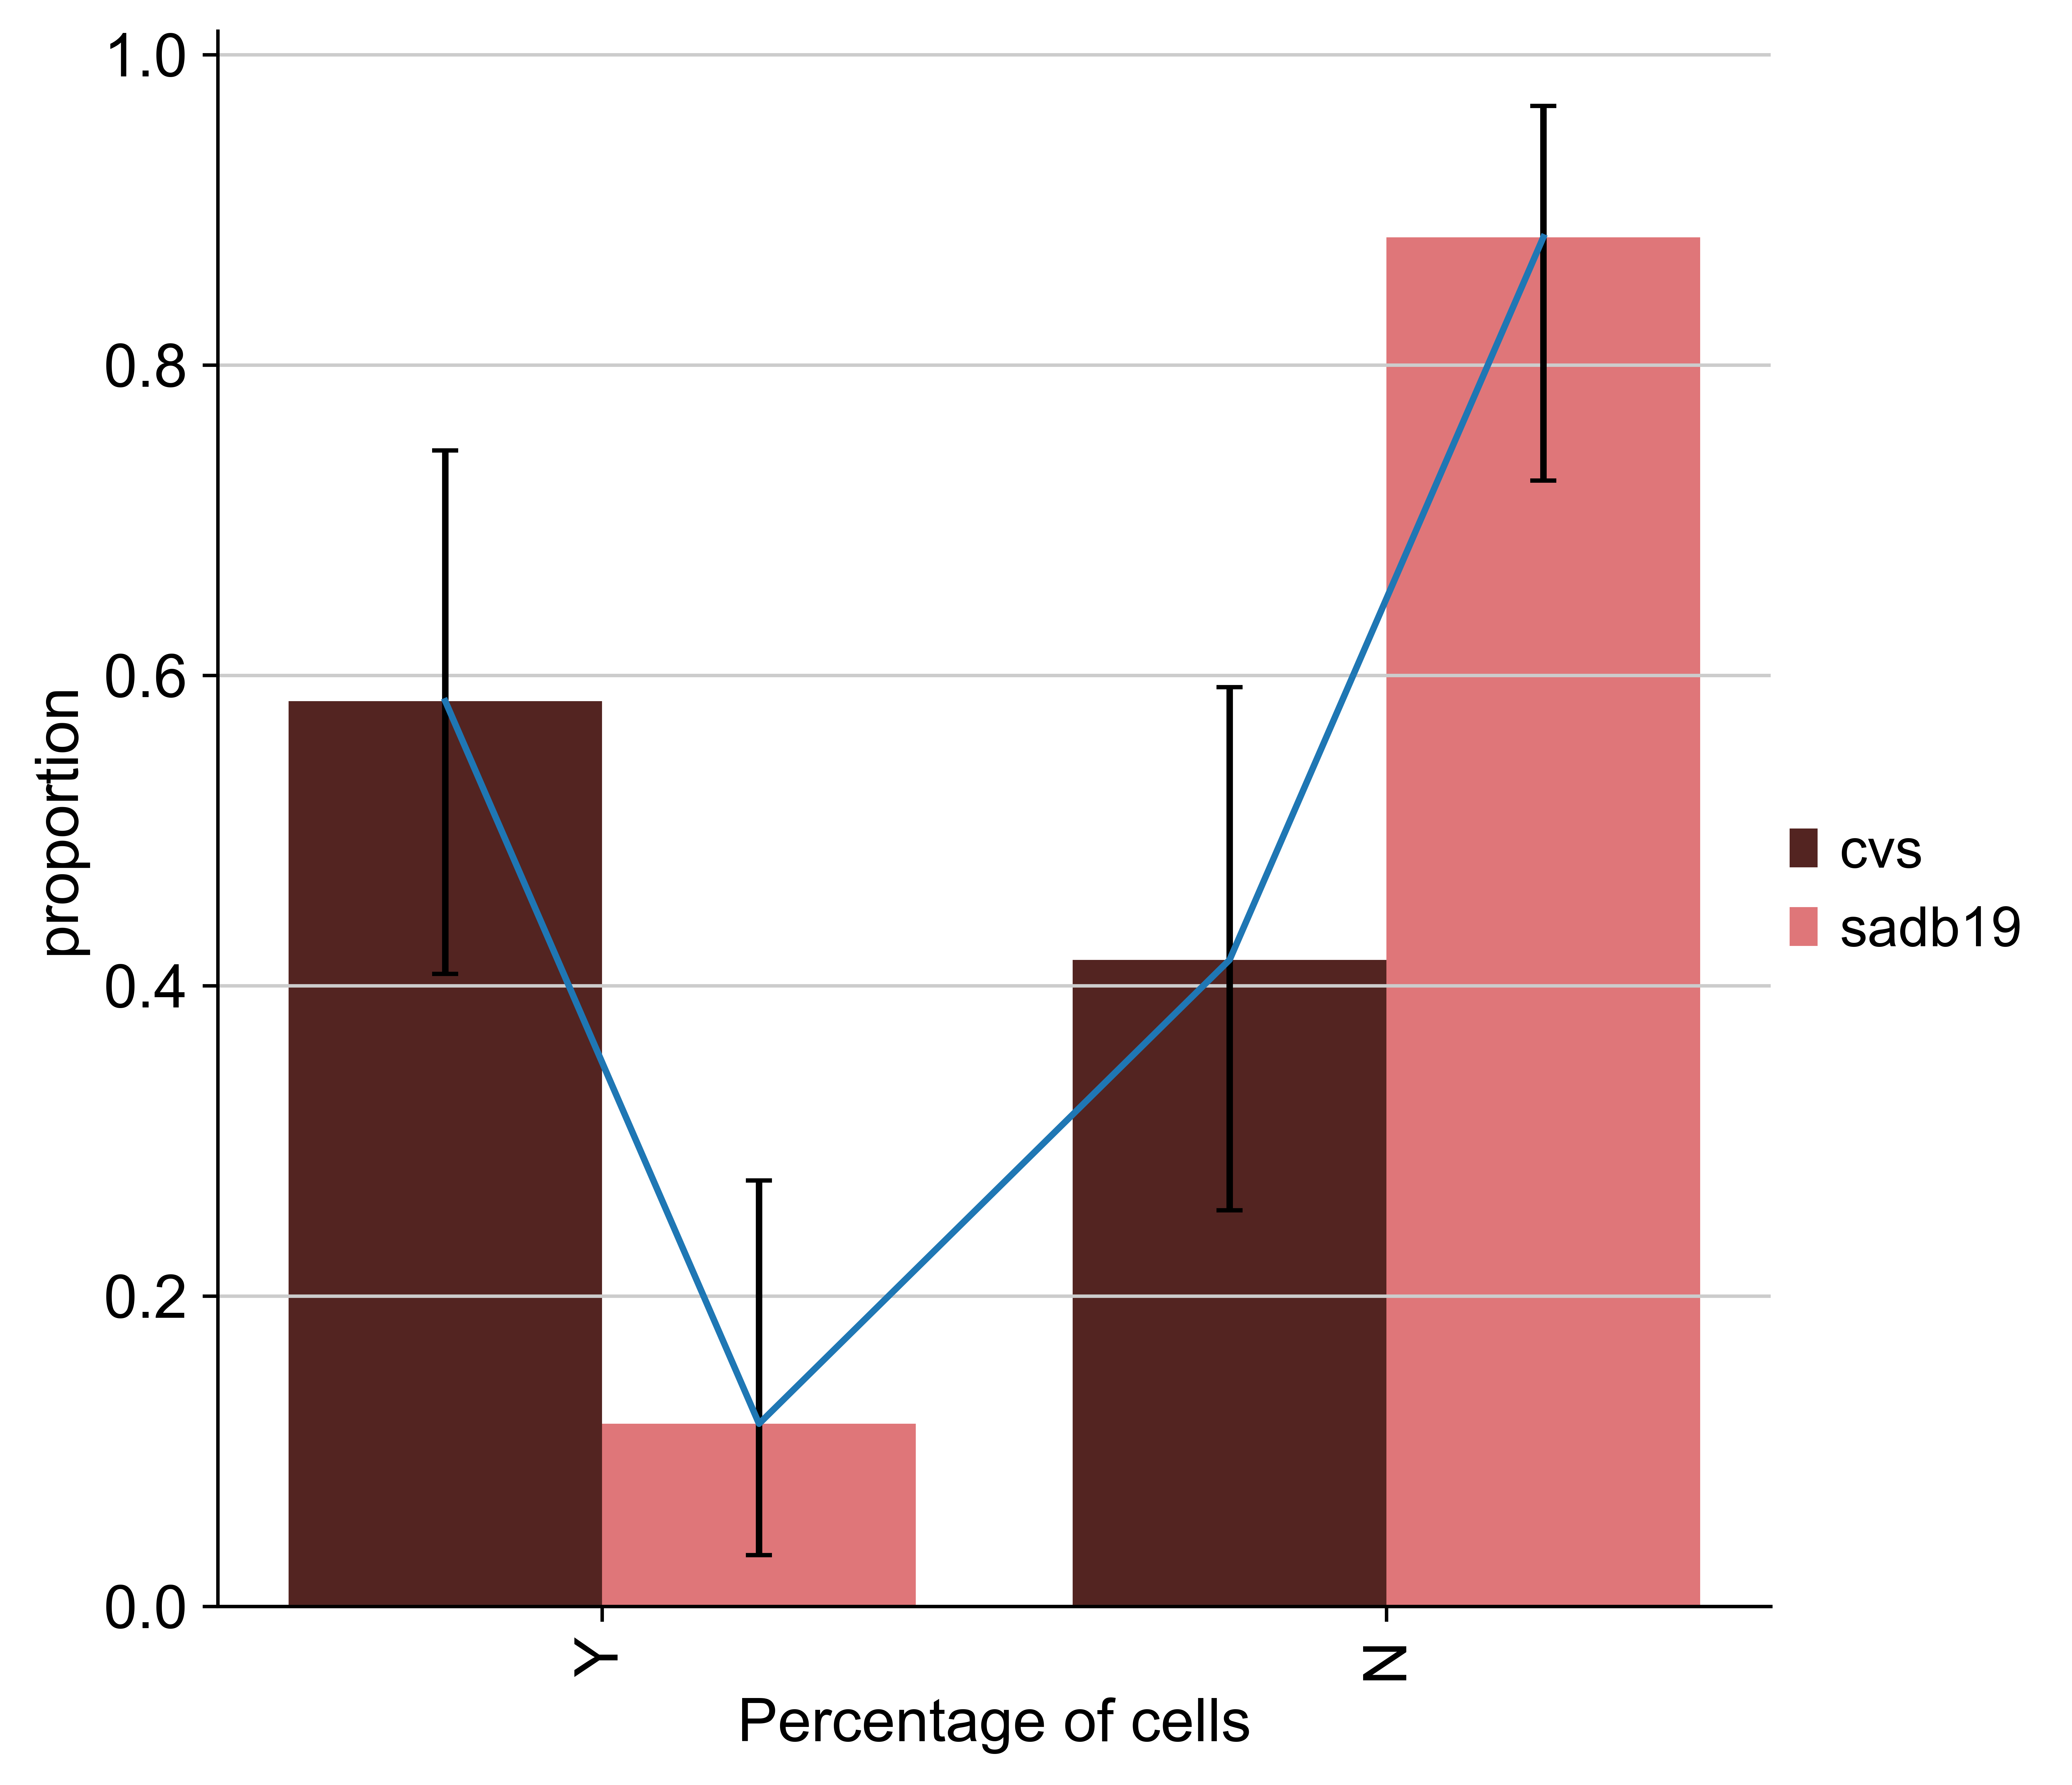

In [42]:
rabies_palette=['#5b1c19','#f16469']

g = sns.catplot(
    data=firing, kind="bar",
    x="action_potential", y="proportion", hue="strain",
    errorbar=None, palette=rabies_palette, height=6
)

p_10 = [(0.583333-0.4075652408917766),
        (0.117647-0.03300168033630262),
        (0.416667-0.2551410483262834),
        (0.882353-0.7254965128576444)]
p_90 = [(0.7448589516737166-0.583333),
        (0.2745034871423557-0.117647),
        (0.5924347591082234-0.416667),
        (0.9669983196636973-0.882353)]
M = [0.583333,
     0.117647,
     0.416667,
     0.882353]

yerr = [p_10, # 'down' error
        p_90]  # 'up' error

g.set_axis_labels("Percentage of cells")
g.legend.set_title("")
#Placing error bars
x = [-0.2,0.2,0.8,1.2]
plt.errorbar(x, M, yerr=yerr, capsize=3, ecolor = "black")
plt.xticks(rotation=90)
plt.savefig('../../figs/fig_5/action_potential_props.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [43]:
#Check significance
sad=[4,30]
cvs=[((21/36)*34),((15/36)*34)]
import scipy.stats as stats 
# creating data 
data = [sad, cvs] 
# performing fishers exact test on the data 
odd_ratio, p_value = stats.fisher_exact(data) 
print('odds ratio is : ' + str(odd_ratio)) 
print('p_value is : ' + str(p_value)) 

odds ratio is : 0.09824561403508772
p_value is : 9.367047961277838e-05


### Cell Capacitance

Wilcoxon Ranked Sum to compare distributions for CC:
RanksumsResult(statistic=4.524092430205145, pvalue=6.065521448455412e-06)
TtestResult(statistic=2.6179130427233943, pvalue=0.01133150786570536, df=56.55344066997299)
32.13349283833333
23.092108789470586


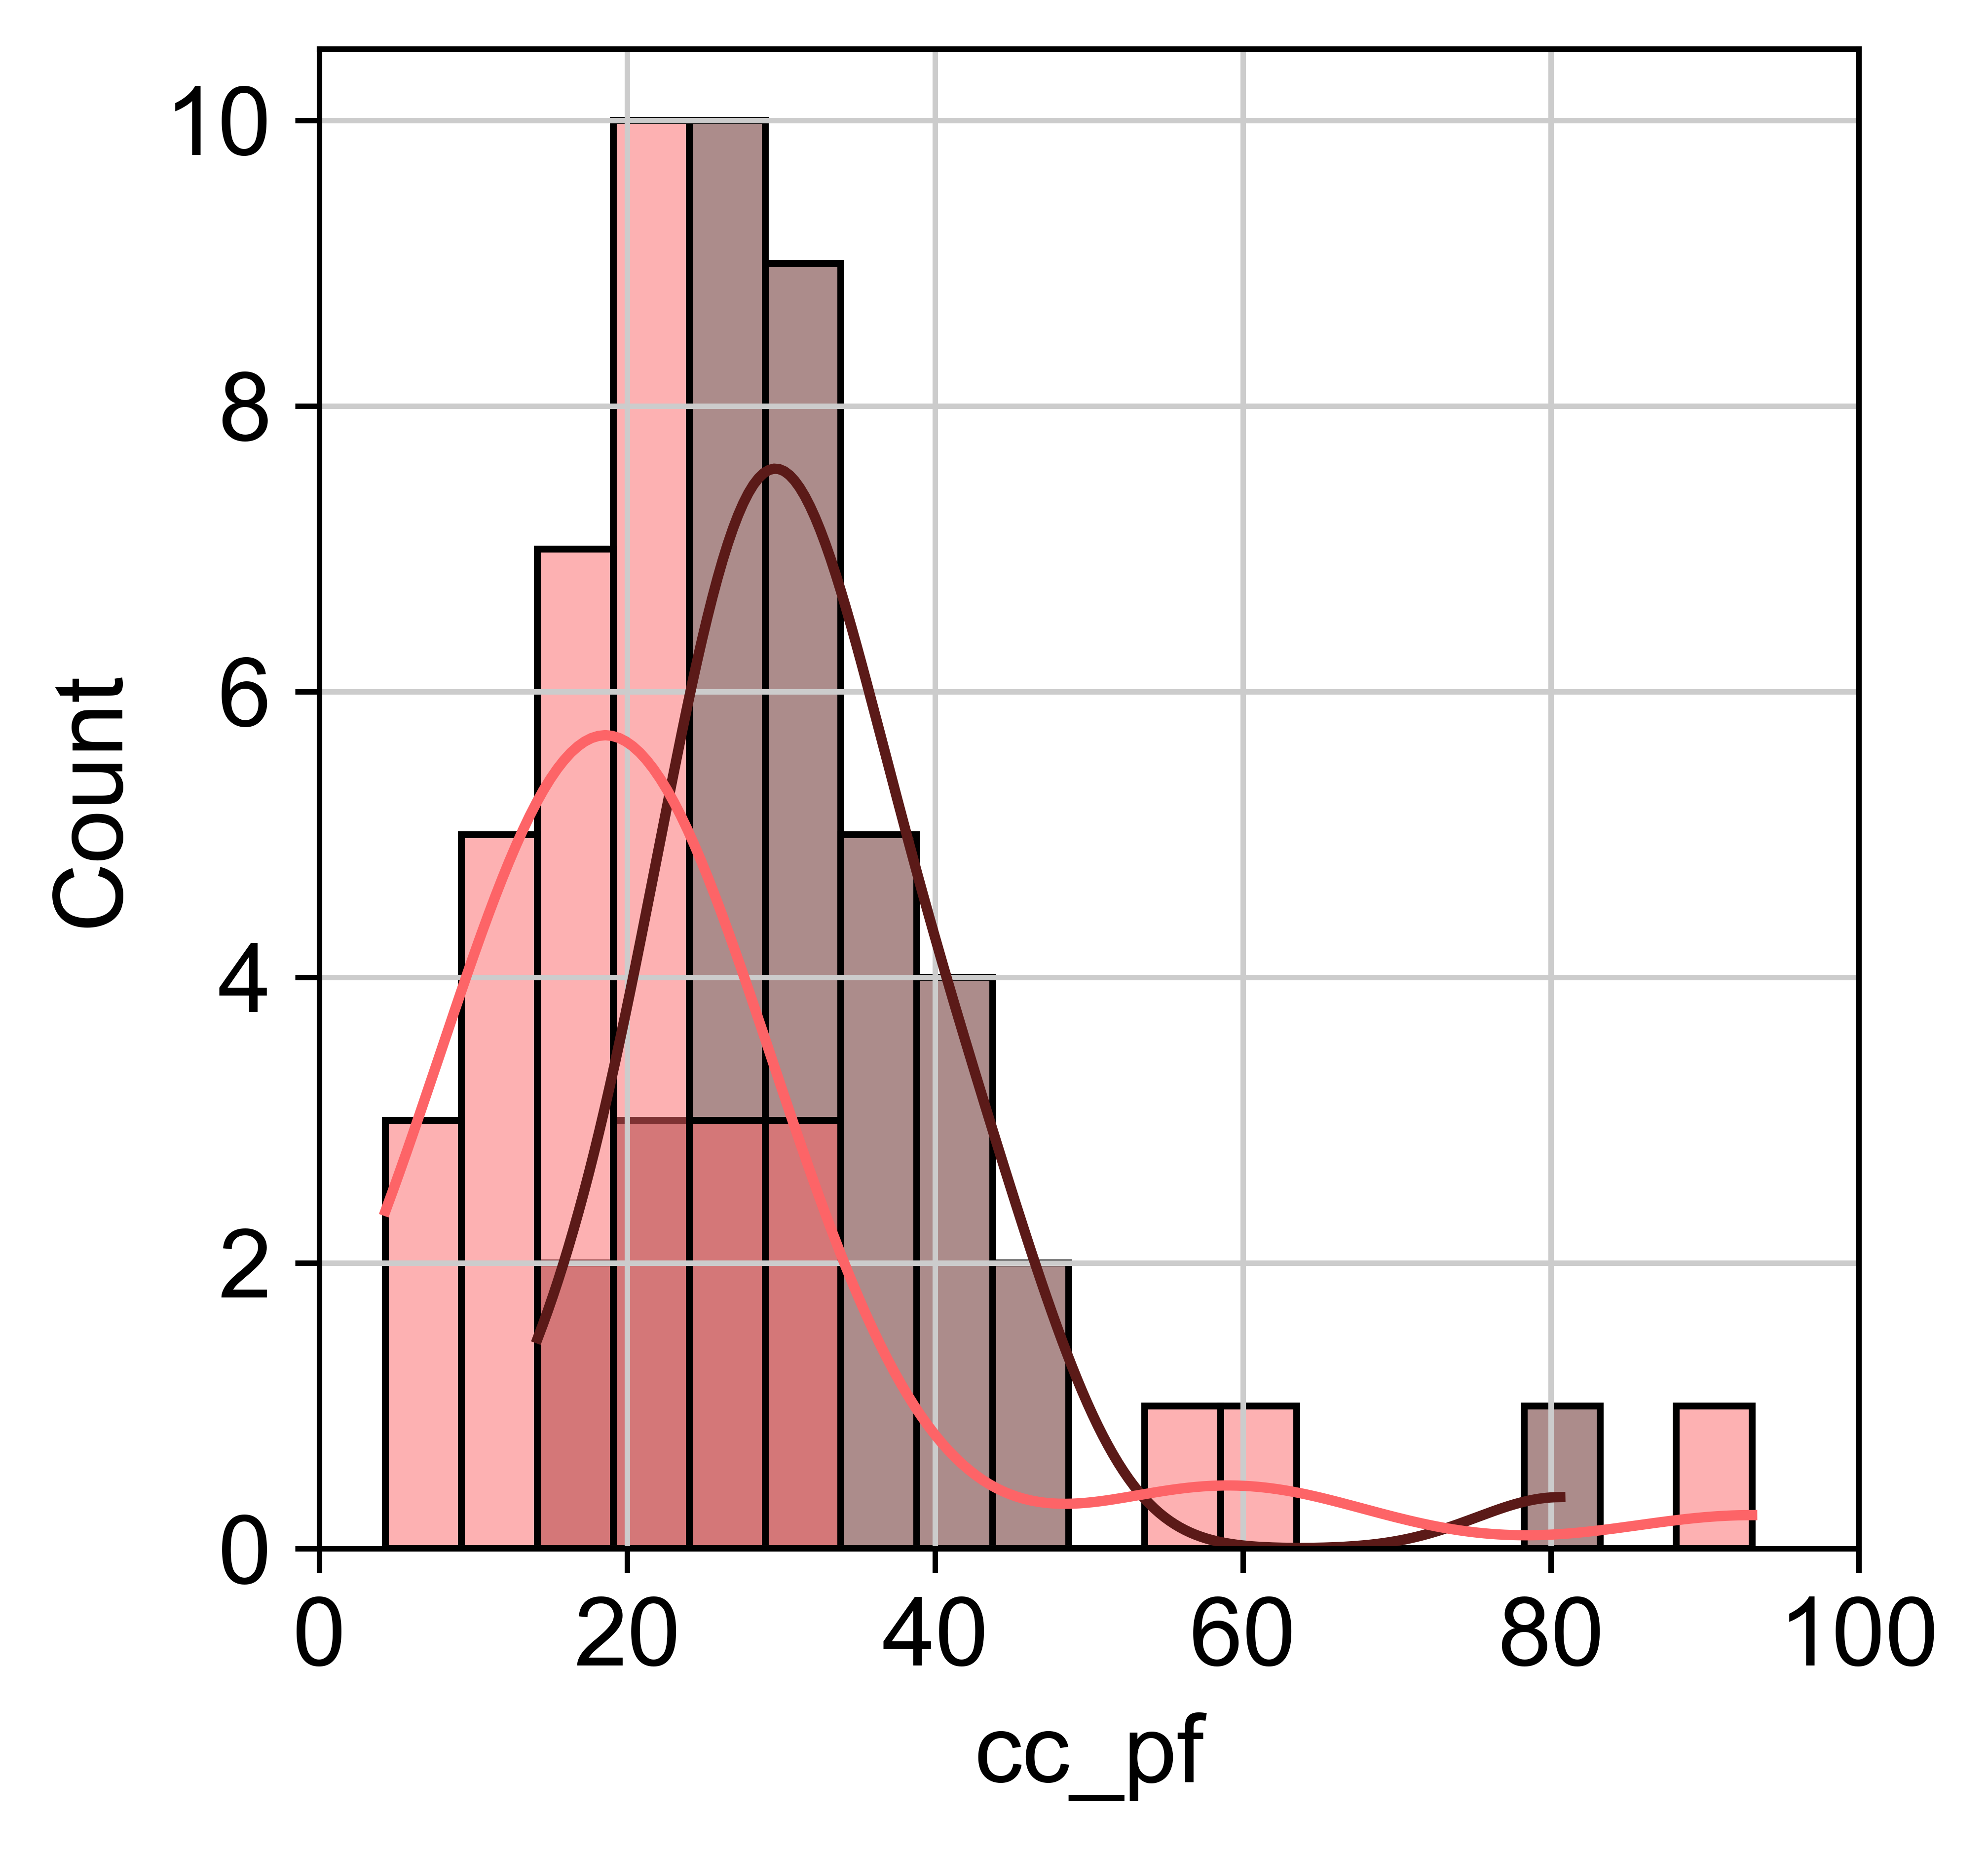

In [9]:
#CC
cvs=recordings.loc[recordings['strain'] == 'cvs']
sad=recordings.loc[recordings['strain'] == 'sadb19']

print('Wilcoxon Ranked Sum to compare distributions for CC:')
import numpy as np
from scipy.stats import ranksums
cvs_dist = cvs['cc_pf']
sad_dist = sad['cc_pf']
print(ranksums(cvs_dist, sad_dist))
print(stats.ttest_ind(cvs_dist, sad_dist, equal_var=False))
print(cvs_dist.mean())
print(sad_dist.mean())

input_min=sad['cc_pf'].min()
input_max=sad['cc_pf'].max()

sns.histplot(data=cvs, x='cc_pf', binwidth=5, binrange=(input_min, input_max),kde=True,color='#5b1a18')
sns.histplot(data=sad, x='cc_pf', binwidth=5, binrange=(input_min, input_max),kde=True,color='#fd6467')

plt.xlim([0, 100])
#plt.savefig('../../figs/fig_5/cell_capacitance.pdf', bbox_inches='tight', format='pdf')
plt.show()

### Input resistance

Wilcoxon Ranked Sum to compare distributions for IR:
RanksumsResult(statistic=-1.727380746078328, pvalue=0.08409930619996642)
TtestResult(statistic=-1.938998155792507, pvalue=0.0577755653014509, df=53.581925290660664)
1382.0364756444444
1819.5570651441176


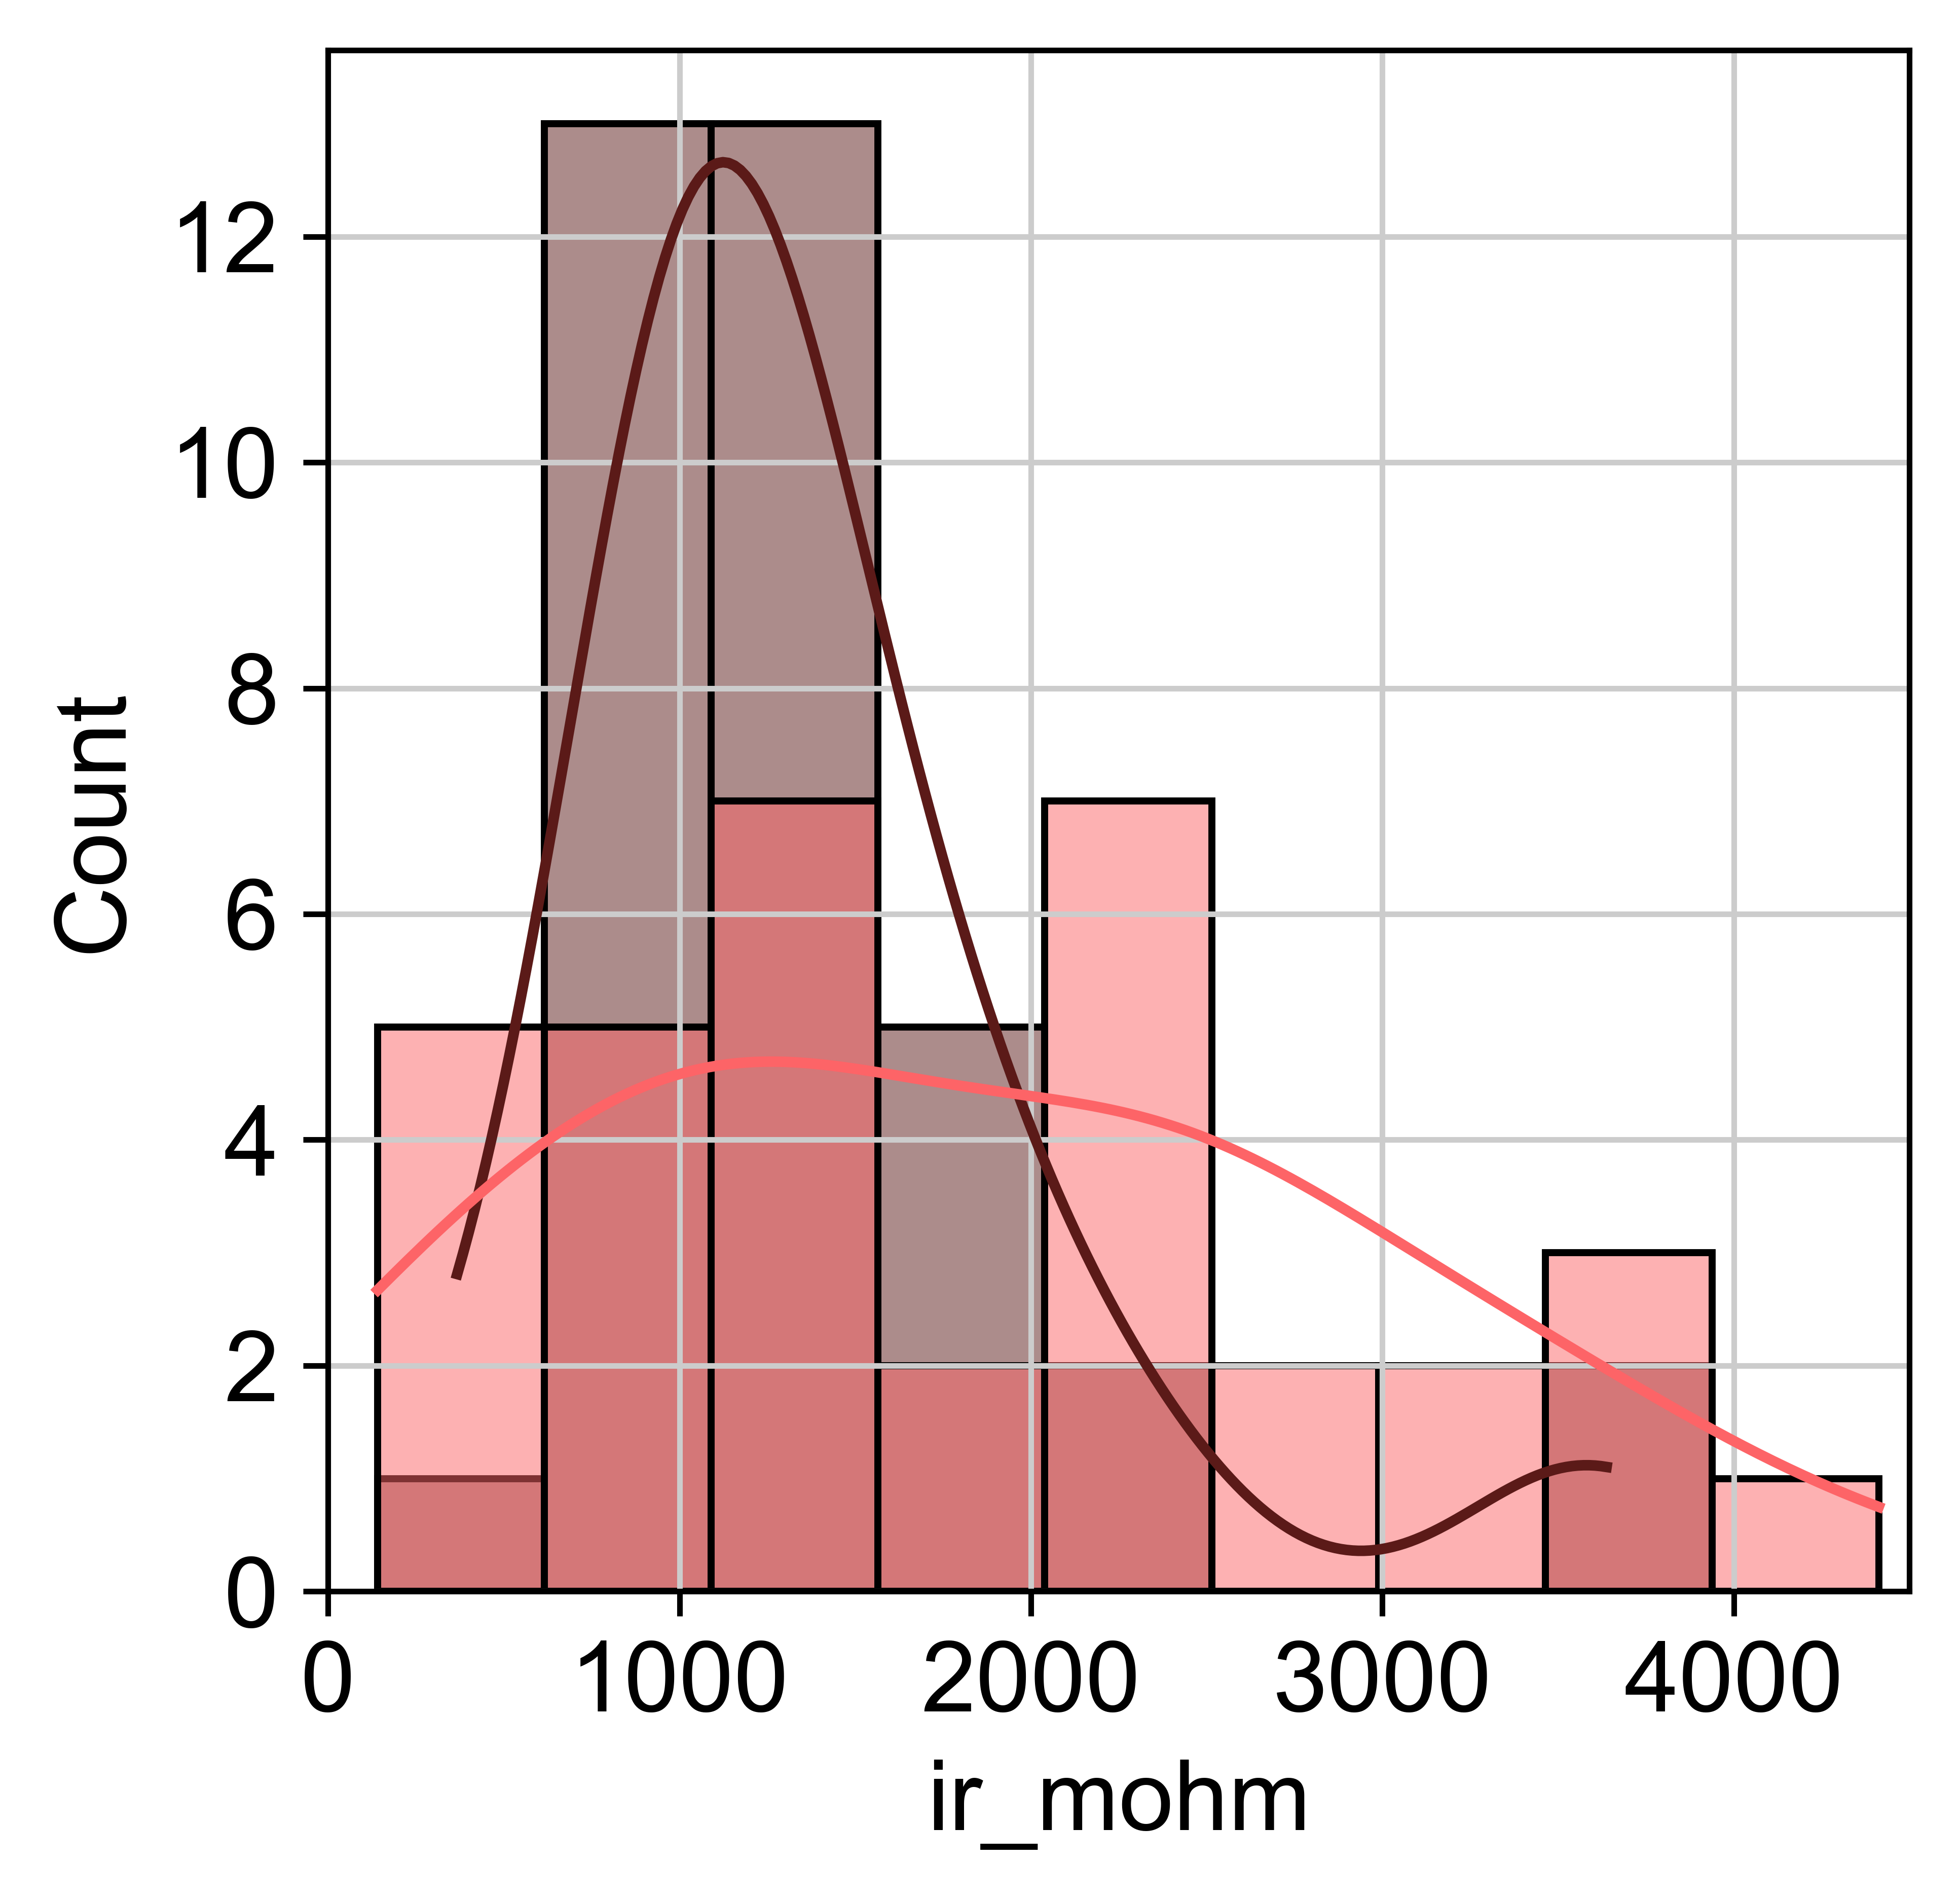

In [10]:
#IR
cvs=recordings.loc[recordings['strain'] == 'cvs']
sad=recordings.loc[recordings['strain'] == 'sadb19']

print('Wilcoxon Ranked Sum to compare distributions for IR:')
import numpy as np
from scipy.stats import ranksums
cvs_dist = cvs['ir_mohm']
sad_dist = sad['ir_mohm']
print(ranksums(cvs_dist, sad_dist))
print(stats.ttest_ind(cvs_dist, sad_dist, equal_var=False))
print(cvs_dist.mean())
print(sad_dist.mean())

input_min=recordings['ir_mohm'].min()
input_max=recordings['ir_mohm'].max()


sns.histplot(data=cvs, x='ir_mohm', binwidth=500, binrange=(input_min, input_max),kde=True,color='#5b1a18')
sns.histplot(data=sad, x='ir_mohm', binwidth=500, binrange=(input_min, input_max),kde=True,color='#fd6467')

plt.xlim([0, 4500])
#plt.savefig('../../figs/fig_5/input_resistance.pdf', bbox_inches='tight', format='pdf')
plt.show()

### Resting Membrane Potential

Wilcoxon Ranked Sum to compare distributions for IR:
RanksumsResult(statistic=-3.983551516466348, pvalue=6.78929453979543e-05)

TtestResult(statistic=-3.9414108944367805, pvalue=0.00025257214242595277, df=49.90624384716669)
-38.01150107194444
-25.55658111102941


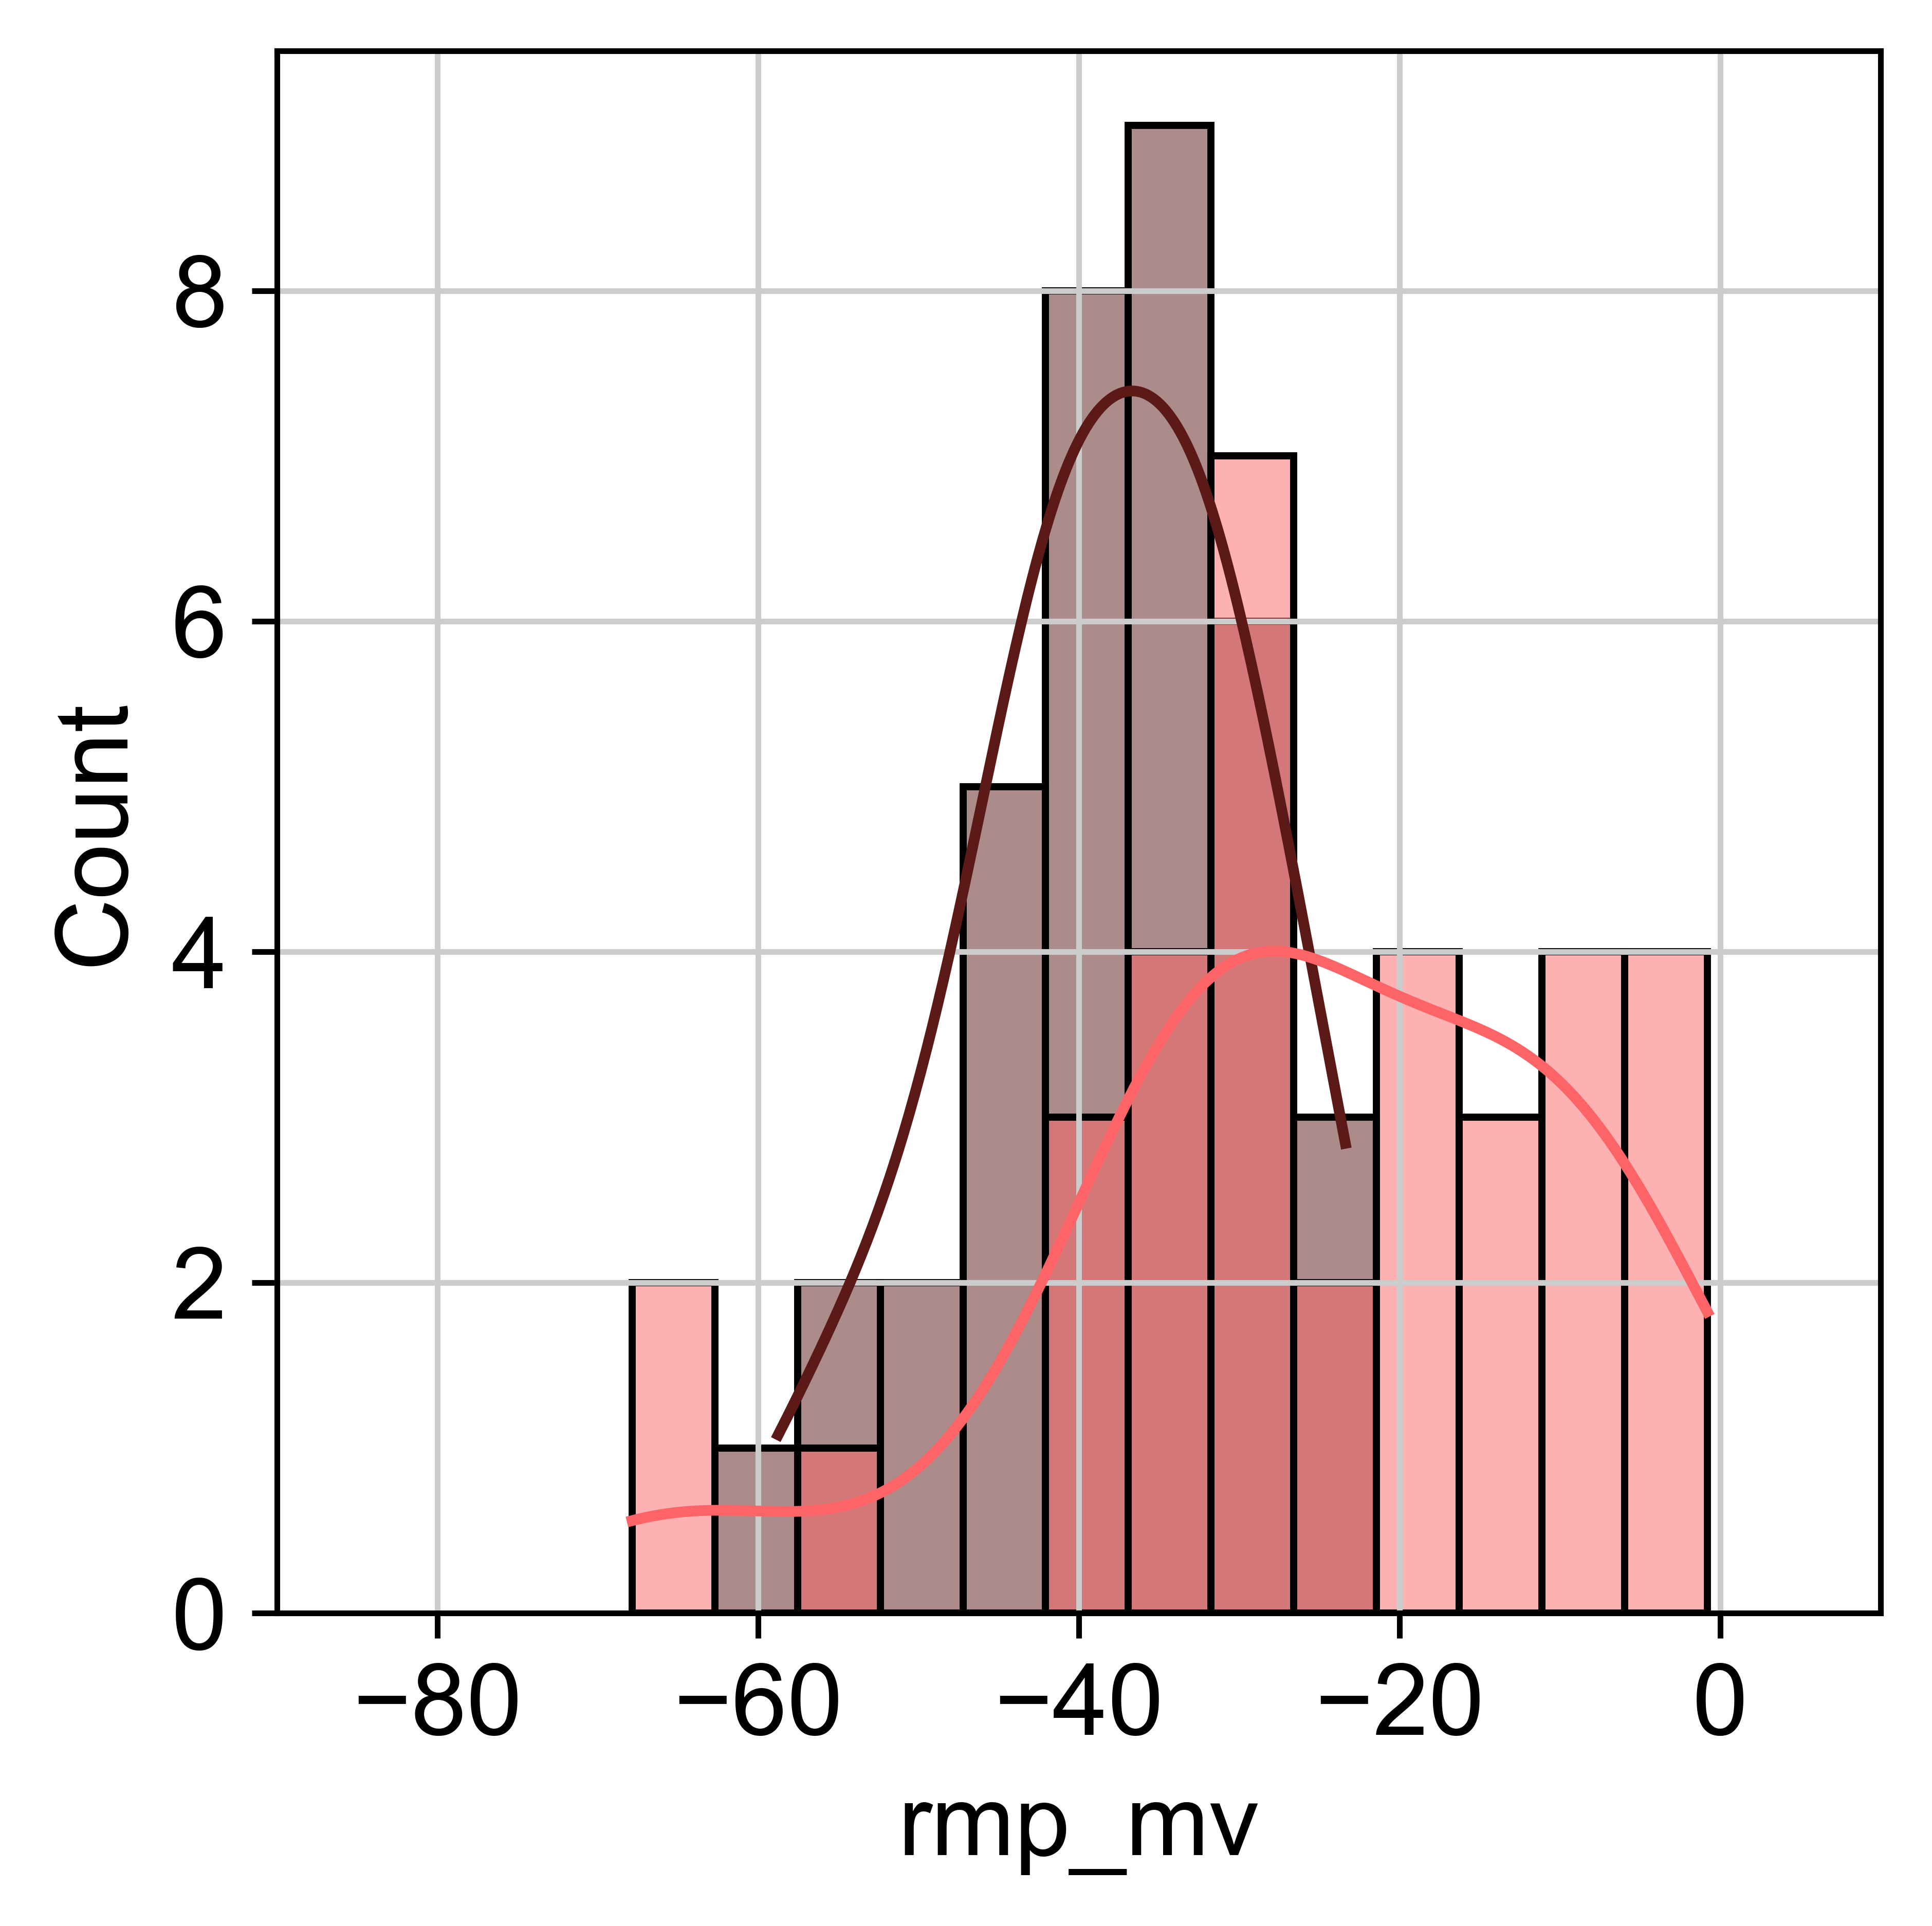

In [11]:
#RMP
cvs=recordings.loc[recordings['strain'] == 'cvs']
sad=recordings.loc[recordings['strain'] == 'sadb19']

print('Wilcoxon Ranked Sum to compare distributions for RMP:')
import numpy as np
from scipy.stats import ranksums
cvs_dist = cvs['rmp_mv']
sad_dist = sad['rmp_mv']
print(ranksums(cvs_dist, sad_dist))
print()
print(stats.ttest_ind(cvs_dist, sad_dist, equal_var=False))
print(cvs_dist.mean())
print(sad_dist.mean())

input_min=recordings['rmp_mv'].min()
input_max=recordings['rmp_mv'].max()


sns.histplot(data=cvs, x='rmp_mv', binwidth=5, binrange=(input_min, input_max),kde=True,color='#5b1a18')
sns.histplot(data=sad, x='rmp_mv', binwidth=5, binrange=(input_min, input_max),kde=True,color='#fd6467')

plt.xlim([-90, 10])
#plt.savefig('../../figs/fig_5/resting_membrane_potential.pdf', bbox_inches='tight', format='pdf')
plt.show()

### Cell type props

In [63]:
def quantify_by_dataset(dataset, #dataset to split
                   ids #list of IDs to split by
                  ):
    cell_props=pd.DataFrame()

    for i in ids:
        temp = dataset.loc[dataset['dataset_id'] == i]
        temp_h = temp.loc[temp['viral_strain'] == 'SADB19']
        temp_r = temp.loc[temp['viral_strain'] == 'CVS-N2c']
        temp_u = temp.loc[temp['dataset_id'].isin(['u1'])]
        #Calculate proportions for each
        temp_r_props=pd.DataFrame(temp_r['subclass'].value_counts()/len(temp_r)*100)
        temp_r_props['dataset_id']=f'{i}'
        temp_r_props['viral_strain']='CVS-N2c'
        temp_h_props=pd.DataFrame(temp_h['subclass'].value_counts()/len(temp_h)*100)
        temp_h_props['dataset_id']=f'{i}'
        temp_h_props['viral_strain']='SADB19'
        temp_u_props=pd.DataFrame(temp_u['subclass'].value_counts()/len(temp_u)*100)
        temp_u_props['dataset_id']=f'{i}'
        temp_u_props['viral_strain']='uninfected'
        temp=pd.concat([temp_r_props,temp_h_props,temp_u_props])
        cell_props=pd.concat([cell_props,temp])
    cell_props = cell_props.reset_index()

    return cell_props
        

In [64]:
#Run quantify_by_dataset function
cell_props=quantify_by_dataset(metadata,['s1',
                                                     's2',
                                                    's3',
                                                    's4',
                                                    's5',
                                                    'c1',
                                                    'c2',
                                                    'c3',
                                                    'c4',
                                                     'u1'
                                                    ])

cell_props

,subclass,count,dataset_id,viral_strain
0,EN-Immature,66.734280,s1,SADB19
1,IN-MGE,7.505071,s1,SADB19
2,IPC,6.288032,s1,SADB19
3,Astrocyte,5.273834,s1,SADB19
4,EN-L2_3-IT,4.665314,s1,SADB19
...,...,...,...,...
109,EN-Deep Layer,2.840219,u1,uninfected
110,IN-MGE,2.809842,u1,uninfected
111,IN-CGE,1.640340,u1,uninfected
112,Oligo,0.987242,u1,uninfected


In [66]:
cell_props

,subclass,count,dataset_id,viral_strain
0,EN-Immature,66.734280,s1,SADB19
1,IN-MGE,7.505071,s1,SADB19
2,IPC,6.288032,s1,SADB19
3,Astrocyte,5.273834,s1,SADB19
4,EN-L2_3-IT,4.665314,s1,SADB19
...,...,...,...,...
109,EN-Deep Layer,2.840219,u1,uninfected
110,IN-MGE,2.809842,u1,uninfected
111,IN-CGE,1.640340,u1,uninfected
112,Oligo,0.987242,u1,uninfected


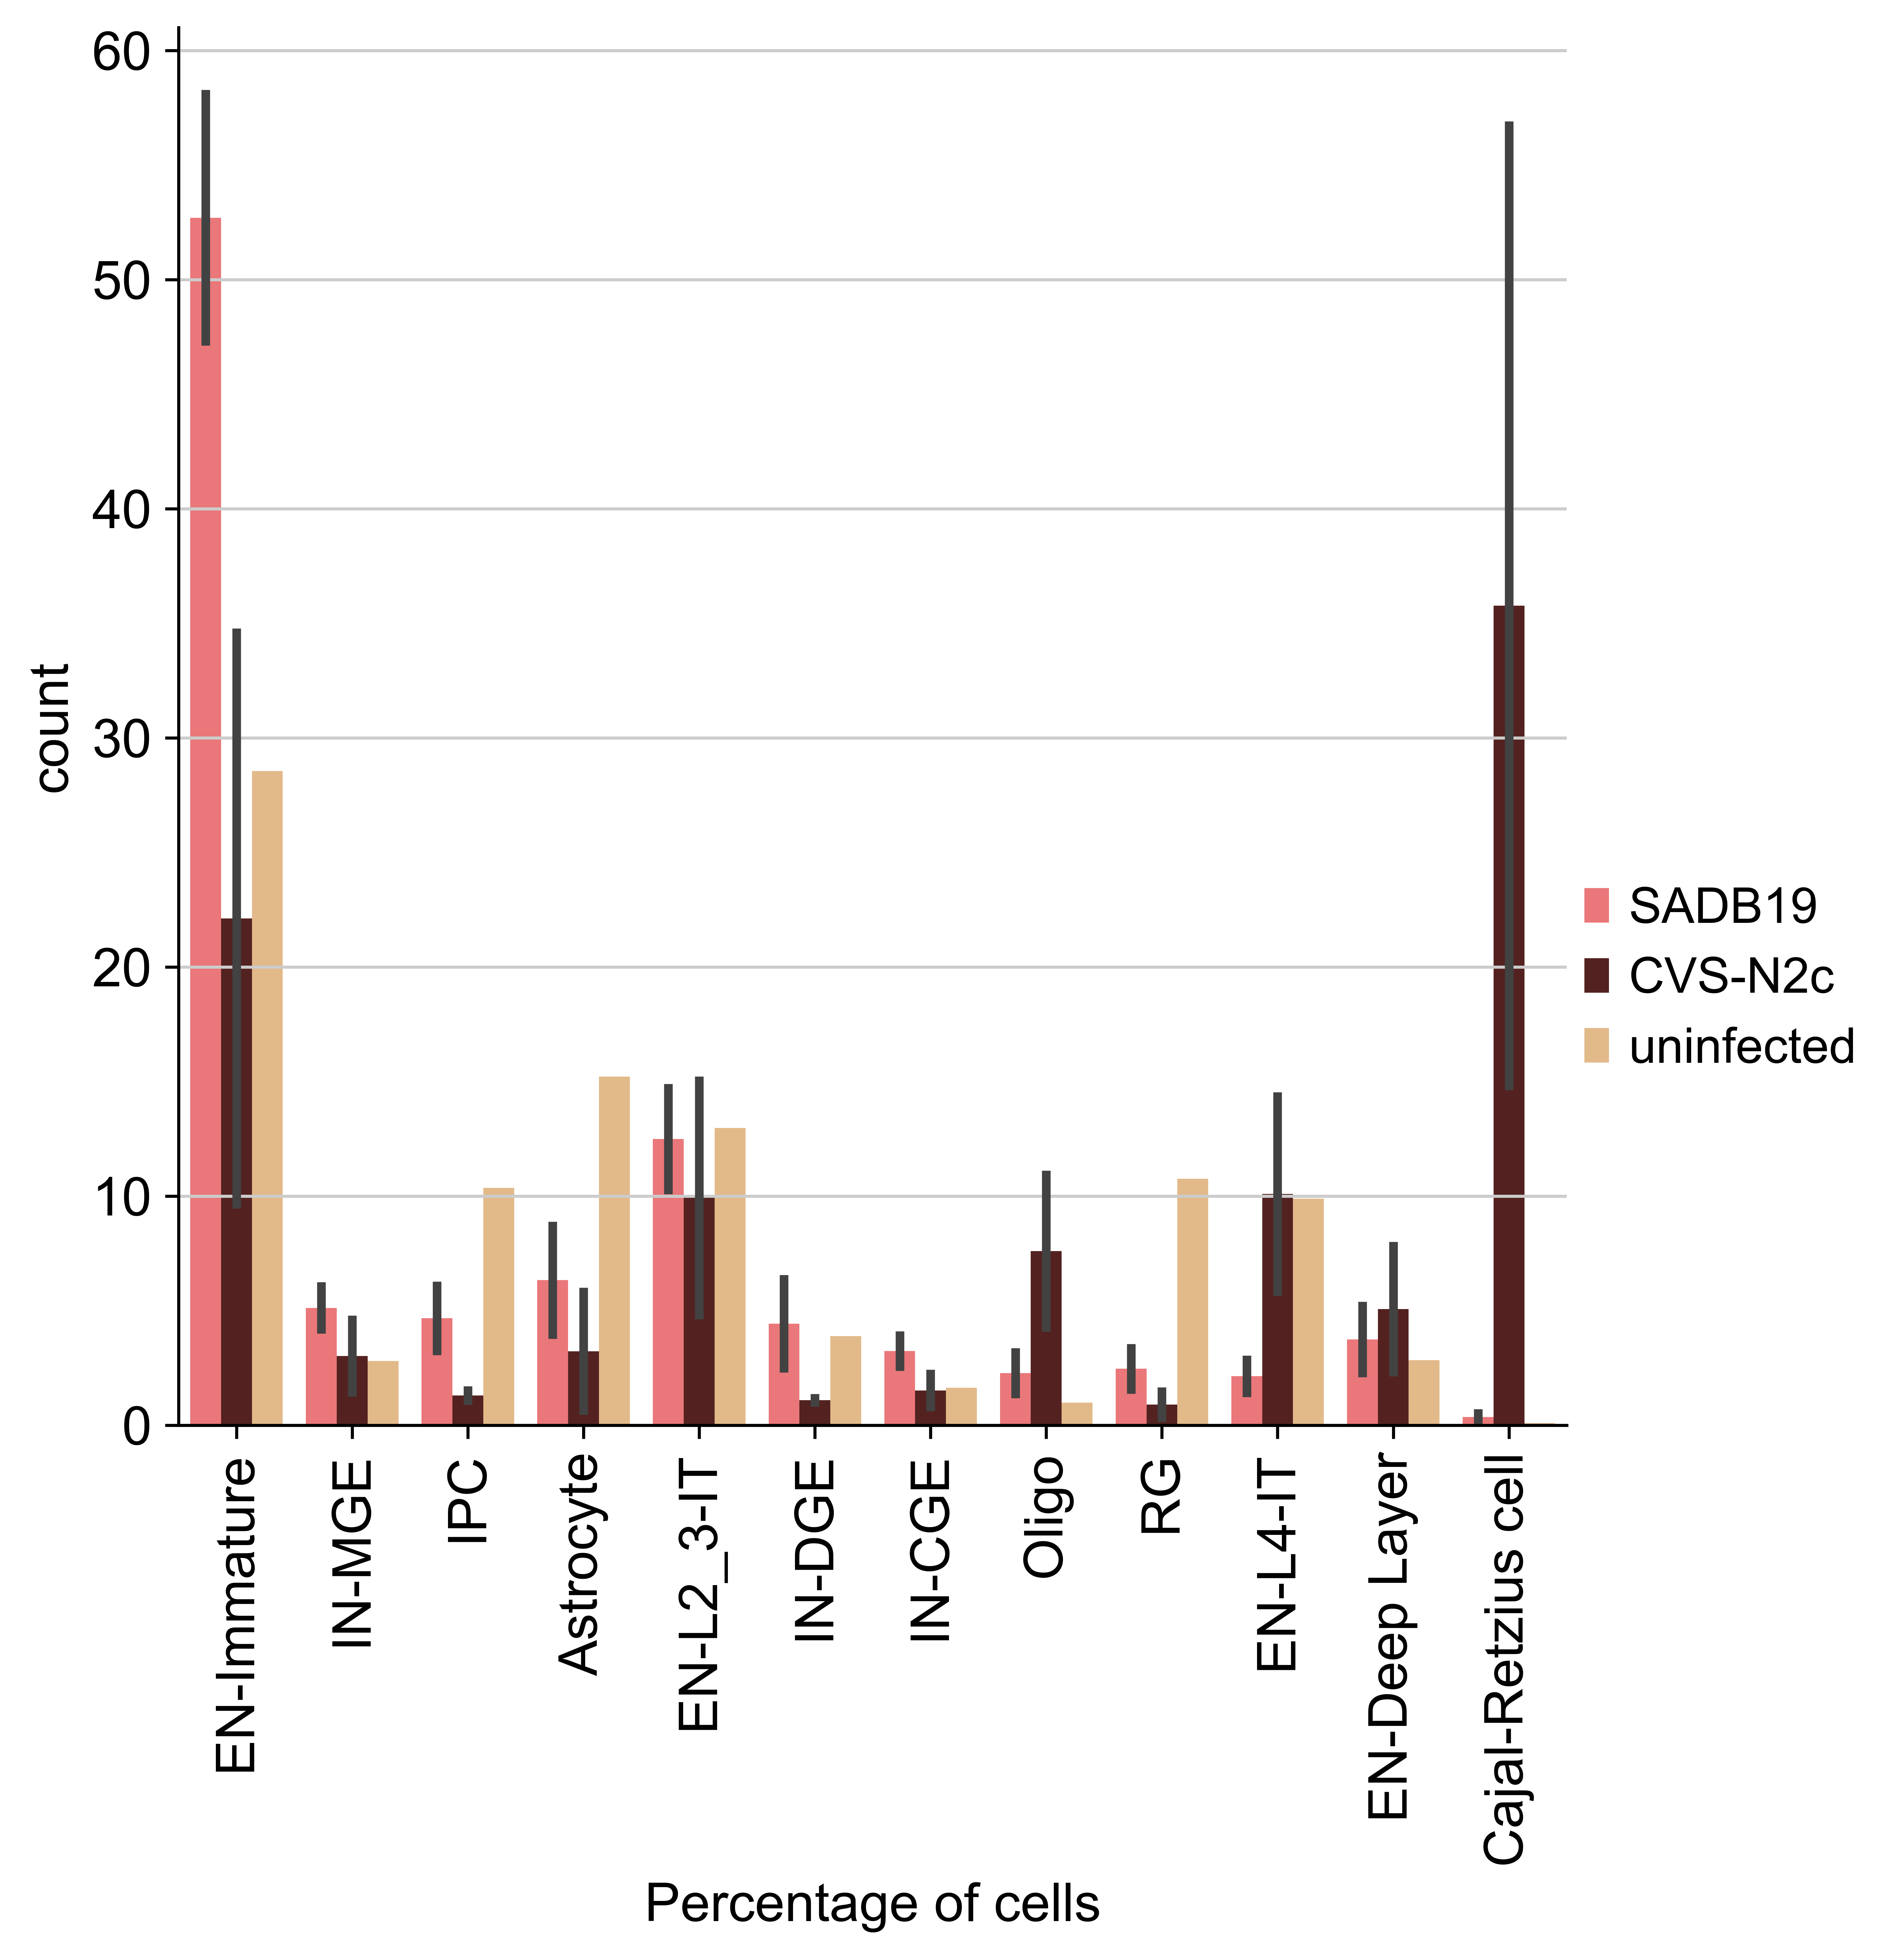

In [67]:
#Set up plotting parameters
rabies_palette=['#fd6467','#5b1a18','#f1bb7b']

g = sns.catplot(
    data=cell_props, kind="bar",
    x="subclass", y="count", hue="viral_strain",
    errorbar="se", palette=rabies_palette, height=6
)

g.set_axis_labels("Percentage of cells")
g.legend.set_title("")
plt.xticks(rotation=90)
plt.savefig('../../figs/fig_5/cell_props_by_strain.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [68]:
#THIS DOES NOT HAVE POST HOC CORRECTION APPLIED, MULTIPLY P VALUES BY 24!
clusters=cell_props.subclass.unique()
for i in clusters:
    temp = cell_props.loc[cell_props.subclass == i]
    print(f'{i}, SAD B19')
    rabies=temp.loc[temp.viral_strain == 'SADB19']
    rabies=rabies.loc[temp.dataset_id != 'u1']
    rabies=rabies.loc[temp.dataset_id != 'u2']
    rabies['count']=rabies['count'].fillna(0)
    uninfected=temp.loc[temp.viral_strain == 'uninfected']
    uninfected=uninfected.dropna()
    print(stats.ttest_1samp(rabies['count'], popmean=uninfected['count'].mean()))
    print(f'{i}, CVS-N2c')
    helper=temp.loc[temp.viral_strain == 'CVS-N2c']
    helper=helper.loc[helper.dataset_id != 'u1']
    helper=helper.loc[helper.dataset_id != 'u2']
    helper['count']=helper['count'].fillna(0)
    print(stats.ttest_1samp(helper['count'], popmean=uninfected['count'].mean()))
    print()

EN-Immature, SAD B19
TtestResult(statistic=4.4775175908704705, pvalue=0.011010836179498135, df=4)
EN-Immature, CVS-N2c
TtestResult(statistic=-0.5156353721941905, pvalue=0.6417019397615882, df=3)

IN-MGE, SAD B19
TtestResult(statistic=2.4782071247116733, pvalue=0.06834235398855679, df=4)
IN-MGE, CVS-N2c
TtestResult(statistic=0.1342443032315405, pvalue=0.9017093978757682, df=3)

IPC, SAD B19
TtestResult(statistic=-4.01756020201271, pvalue=0.01589654976764848, df=4)
IPC, CVS-N2c
TtestResult(statistic=-41.51809120621398, pvalue=0.015330586963959295, df=1)

Astrocyte, SAD B19
TtestResult(statistic=-3.7514022048868747, pvalue=0.01992282636828814, df=4)
Astrocyte, CVS-N2c
TtestResult(statistic=-4.639224143236639, pvalue=0.018874424394421673, df=3)

EN-L2_3-IT, SAD B19
TtestResult(statistic=-0.21655853881806605, pvalue=0.8391486895465803, df=4)
EN-L2_3-IT, CVS-N2c
TtestResult(statistic=-0.5963000932216199, pvalue=0.5929722954215586, df=3)

IN-DGE, SAD B19
TtestResult(statistic=0.27944656321337